# Multi-class Classification: Student Outcome Prediction

## Objective
Build, optimize, and evaluate a fully-tuned multi-class classification model to predict:
- 0 = Distinction (excellent performance)
- 1 = Pass (acceptable performance)
- 2 = Fail (below threshold)
- 3 = Withdrawn (course withdrawal)

## CRISP-DM Stage
Modelling and Evaluation

## Approach
1. Test multiple baseline algorithms
2. Cross-validate promising models
3. Hyperparameter optimization on the best model
4. Final evaluation and serialization for downstream analysis

## Section 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
import xgboost as xgb

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported successfully')
print('=' * 80)

All libraries imported successfully


## Section 2: Load and Explore Data

In [2]:
print('\n' + '=' * 80)
print('LOADING DATA')
print('=' * 80)

features = pd.read_pickle('../2_Outputs/features_prepared.pkl')
target = pd.read_pickle('../2_Outputs/target_multiclass.pkl')
df_encoded = pd.read_pickle('../2_Outputs/df_encoded_full.pkl')

print(f'\nFeatures shape: {features.shape}')
print(f'Target shape: {target.shape}')
print(f'\nFeature names ({len(features.columns)} total):')
print(features.columns.tolist()[:10], '...')

print('\n' + '=' * 80)
print('TARGET DISTRIBUTION (Multi-class)')
print('=' * 80)

class_names = ['Distinction', 'Pass', 'Fail', 'Withdrawn']
print(f'\nClass distribution:')
for idx, name in enumerate(class_names):
    count = (target == idx).sum()
    pct = 100 * count / len(target)
    print(f'  {idx} = {name:15s}: {count:5d} ({pct:5.2f}%)')

print(f'\nNo missing values in target: {target.isnull().sum() == 0}')
print(f'Data types in features: {features.dtypes.nunique()} unique types')


LOADING DATA

Features shape: (32593, 46)
Target shape: (32593,)

Feature names (46 total):
['gender', 'num_of_prev_attempts', 'studied_credits', 'disability', 'total_clicks', 'avg_clicks_per_day', 'std_clicks', 'max_clicks_per_day', 'date_min', 'date_max'] ...

TARGET DISTRIBUTION (Multi-class)

Class distribution:
  0 = Distinction    :  3024 ( 9.28%)
  1 = Pass           : 12361 (37.93%)
  2 = Fail           :  7052 (21.64%)
  3 = Withdrawn      : 10156 (31.16%)

No missing values in target: True
Data types in features: 4 unique types


## Section 3: Train-Test Split

In [3]:
print('\n' + '=' * 80)
print('STRATIFIED TRAIN-TEST SPLIT')
print('=' * 80)

X_train, X_test, y_train, y_test = train_test_split(
    features, target,
    test_size=0.2,
    random_state=42,
    stratify=target
)

print(f'\nTraining set: {X_train.shape}')
print(f'Test set: {X_test.shape}')

print(f'\nTraining set class distribution:')
for idx, name in enumerate(class_names):
    count = (y_train == idx).sum()
    pct = 100 * count / len(y_train)
    print(f'  {name:15s}: {count:5d} ({pct:5.2f}%)')

print(f'\nTest set class distribution:')
for idx, name in enumerate(class_names):
    count = (y_test == idx).sum()
    pct = 100 * count / len(y_test)
    print(f'  {name:15s}: {count:5d} ({pct:5.2f}%)')


STRATIFIED TRAIN-TEST SPLIT

Training set: (26074, 46)
Test set: (6519, 46)

Training set class distribution:
  Distinction    :  2419 ( 9.28%)
  Pass           :  9889 (37.93%)
  Fail           :  5641 (21.63%)
  Withdrawn      :  8125 (31.16%)

Test set class distribution:
  Distinction    :   605 ( 9.28%)
  Pass           :  2472 (37.92%)
  Fail           :  1411 (21.64%)
  Withdrawn      :  2031 (31.16%)


## Section 4: Baseline Models

In [4]:
print('\n' + '=' * 80)
print('BASELINE MODEL EVALUATION')
print('=' * 80)

baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, tree_method='hist', n_jobs=-1),
}

baseline_results = {}

for name, model in baseline_models.items():
    print(f'\n{name}:')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    baseline_results[name] = {'model': model, 'accuracy': accuracy, 'f1': f1}
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-Score (weighted): {f1:.4f}')

best_baseline = max(baseline_results.items(), key=lambda x: x[1]['f1'])
print(f'\n✓ Best baseline model: {best_baseline[0]} (F1={best_baseline[1]["f1"]:.4f})')


BASELINE MODEL EVALUATION

Logistic Regression:
  Accuracy: 0.6924
  F1-Score (weighted): 0.6419

Random Forest:
  Accuracy: 0.7030
  F1-Score (weighted): 0.6596

Gradient Boosting:
  Accuracy: 0.7092
  F1-Score (weighted): 0.6643

XGBoost:
  Accuracy: 0.7093
  F1-Score (weighted): 0.6803

✓ Best baseline model: XGBoost (F1=0.6803)


## Section 5: Cross-Validation

In [5]:
print('\n' + '=' * 80)
print('CROSS-VALIDATION (5-Fold Stratified)')
print('=' * 80)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in baseline_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='f1_weighted', n_jobs=-1)
    cv_results[name] = scores
    print(f'\n{name}:')
    print(f'  Fold scores: {[f"{s:.4f}" for s in scores]}')
    print(f'  Mean: {scores.mean():.4f} (+/- {scores.std():.4f})')

best_cv_model = max(cv_results.items(), key=lambda x: x[1].mean())
print(f'\n✓ Best CV model: {best_cv_model[0]} (Mean F1={best_cv_model[1].mean():.4f})')


CROSS-VALIDATION (5-Fold Stratified)

Logistic Regression:
  Fold scores: ['0.6297', '0.6440', '0.6252', '0.6339', '0.6362']
  Mean: 0.6338 (+/- 0.0063)

Random Forest:
  Fold scores: ['0.6633', '0.6723', '0.6602', '0.6610', '0.6602']
  Mean: 0.6634 (+/- 0.0046)

Gradient Boosting:
  Fold scores: ['0.6610', '0.6646', '0.6570', '0.6616', '0.6654']
  Mean: 0.6619 (+/- 0.0030)

XGBoost:
  Fold scores: ['0.6689', '0.6845', '0.6709', '0.6735', '0.6760']
  Mean: 0.6748 (+/- 0.0054)

✓ Best CV model: XGBoost (Mean F1=0.6748)


## Section 6: Hyperparameter Tuning

In [6]:
print('\n' + '=' * 80)
print('HYPERPARAMETER OPTIMIZATION')
print('=' * 80)

# Define hyperparameter grids for top models
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0]
    },
}

tuned_models = {}

for model_name in ['Random Forest', 'XGBoost']:
    if model_name not in param_grids:
        continue
    
    print(f'\nTuning {model_name}...')
    base_model = baseline_models[model_name]
    param_grid = param_grids[model_name]
    
    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    tuned_models[model_name] = grid_search.best_estimator_
    
    print(f'  Best params: {grid_search.best_params_}')
    print(f'  Best CV score: {grid_search.best_score_:.4f}')

print('\n✓ Hyperparameter tuning complete')


HYPERPARAMETER OPTIMIZATION

Tuning Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
  Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  Best CV score: 0.6633

Tuning XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
  Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
  Best CV score: 0.6754

✓ Hyperparameter tuning complete


## Section 7: Evaluate Tuned Models

In [7]:
print('\n' + '=' * 80)
print('FINAL MODEL EVALUATION (Test Set)')
print('=' * 80)

final_results = {}

for model_name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    final_results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred
    }
    
    print(f'\n{model_name}:')
    print(f'  Accuracy:  {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall:    {recall:.4f}')
    print(f'  F1-Score:  {f1:.4f}')

best_model_name = max(final_results.items(), key=lambda x: x[1]['f1'])[0]
best_model = final_results[best_model_name]['model']
print(f'\n✓ BEST MODEL: {best_model_name}')
print(f'  F1-Score: {final_results[best_model_name]["f1"]:.4f}')


FINAL MODEL EVALUATION (Test Set)

Random Forest:
  Accuracy:  0.7053
  Precision: 0.6830
  Recall:    0.7053
  F1-Score:  0.6612

XGBoost:
  Accuracy:  0.7142
  Precision: 0.6936
  Recall:    0.7142
  F1-Score:  0.6829

✓ BEST MODEL: XGBoost
  F1-Score: 0.6829


## Section 8: Confusion Matrix and Classification Report


CLASSIFICATION REPORT - XGBoost

              precision    recall  f1-score   support

 Distinction       0.60      0.19      0.29       605
        Pass       0.72      0.94      0.82      2472
        Fail       0.58      0.37      0.45      1411
   Withdrawn       0.76      0.84      0.80      2031

    accuracy                           0.71      6519
   macro avg       0.67      0.58      0.59      6519
weighted avg       0.69      0.71      0.68      6519



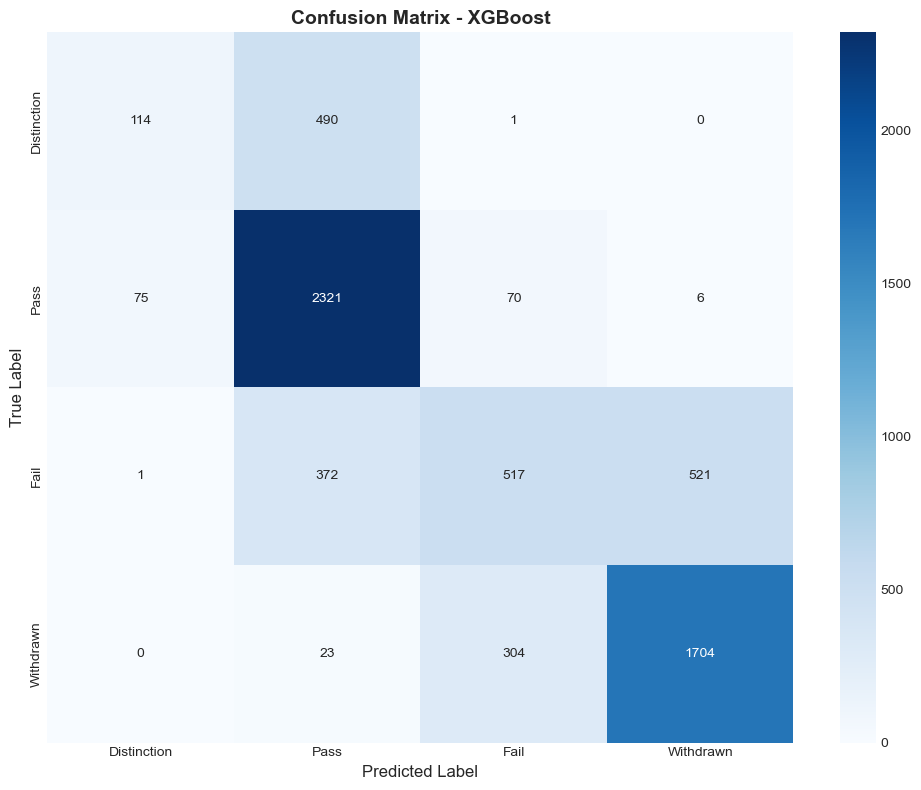


Confusion Matrix:
[[ 114  490    1    0]
 [  75 2321   70    6]
 [   1  372  517  521]
 [   0   23  304 1704]]


In [8]:
print('\n' + '=' * 80)
print(f'CLASSIFICATION REPORT - {best_model_name}')
print('=' * 80)

y_pred_best = final_results[best_model_name]['y_pred']
print('\n' + classification_report(y_test, y_pred_best, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print(f'\nConfusion Matrix:')
print(cm)

## Section 9: Feature Importance


FEATURE IMPORTANCE - XGBoost


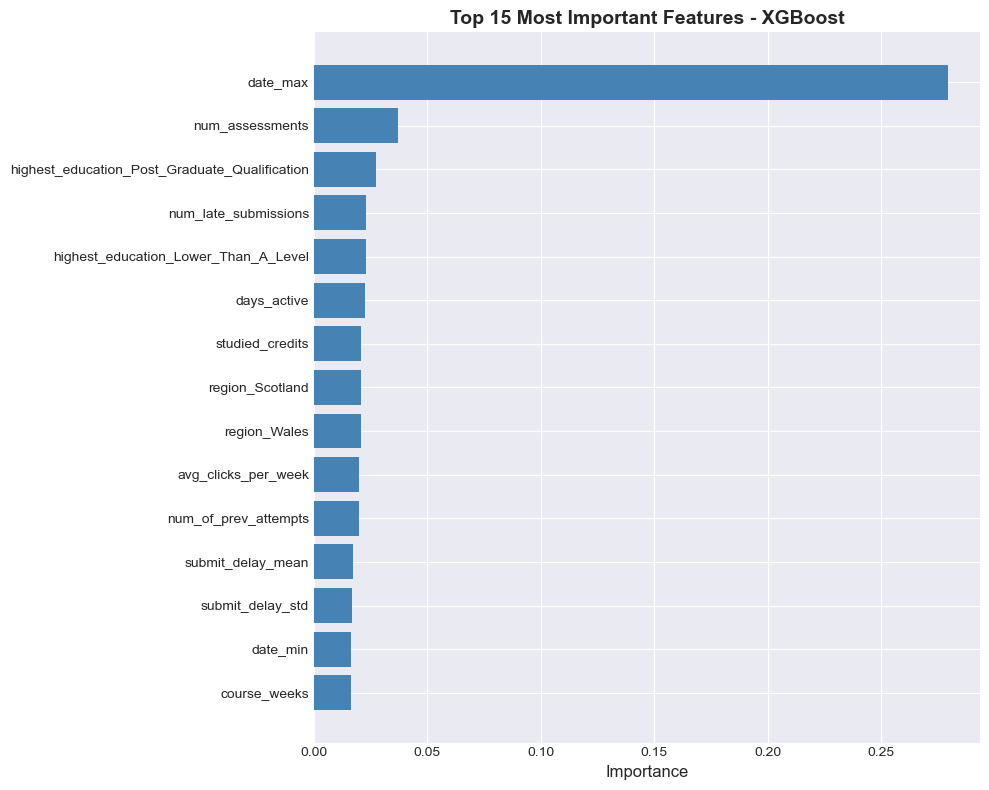


Top 15 Features:
 1. date_max                                 -> 0.279686
 2. num_assessments                          -> 0.036959
 3. highest_education_Post_Graduate_Qualification -> 0.027182
 4. num_late_submissions                     -> 0.022806
 5. highest_education_Lower_Than_A_Level     -> 0.022801
 6. days_active                              -> 0.022739
 7. studied_credits                          -> 0.020887
 8. region_Scotland                          -> 0.020623
 9. region_Wales                             -> 0.020580
10. avg_clicks_per_week                      -> 0.020009
11. num_of_prev_attempts                     -> 0.019796
12. submit_delay_mean                        -> 0.017301
13. submit_delay_std                         -> 0.016634
14. date_min                                 -> 0.016413
15. course_weeks                             -> 0.016317


In [9]:
print('\n' + '=' * 80)
print(f'FEATURE IMPORTANCE - {best_model_name}')
print('=' * 80)

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': features.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    top_features = feature_importance.tail(15)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'].values)
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 15 Most Important Features - {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print('\nTop 15 Features:')
    for idx, (_, row) in enumerate(feature_importance.tail(15).iloc[::-1].iterrows(), 1):
        print(f'{idx:2d}. {row["feature"]:40s} -> {row["importance"]:.6f}')
else:
    print('Feature importances not available for this model')

## Section 10: Save Best Model

In [10]:
print('\n' + '=' * 80)
print('SAVING OPTIMIZED MODEL')
print('=' * 80)

pickle.dump(best_model, open('../2_Outputs/best_classification_model.pkl', 'wb'))

print(f'\n✓ Model saved: best_classification_model.pkl')
print(f'  Model type: {type(best_model).__name__}')
print(f'  Test F1-Score: {final_results[best_model_name]["f1"]:.4f}')
print(f'  Test Accuracy: {final_results[best_model_name]["accuracy"]:.4f}')
print('\nReady for final analysis in 04_Final_Models.ipynb')


SAVING OPTIMIZED MODEL

✓ Model saved: best_classification_model.pkl
  Model type: XGBClassifier
  Test F1-Score: 0.6829
  Test Accuracy: 0.7142

Ready for final analysis in 04_Final_Models.ipynb
